# E-Flux2 (08302023 data + StrainDesign) 
The purpose of the notebook is to run flux balance analysis to find the set of genome scale fluxes that maximizes biomass production.<br><br>
The flux balance analysis results are then compared to reaction rates determined by 13C-metabolic flux analysis (13C-MFA). <br><br>
The results of this notebook will be compared to transcript constained genome scale model flux results via E-Flux2. <br><br>
This notebook looks at glucose, glycerol, acetate, and oleic acid as sole carbon sources. <br><br>
In all cases, parsimonious flux balance analysis (pFBA) was used to prevent degenerate solutions.


### Load imports

In [1]:
import cobra
import pandas as pd
import sys

source_dir = '../src'
sys.path.append(source_dir)

from get_gene_transcript_dictionary import get_gene_transcript_dictionary
from get_reaction_transcript_dictionary import get_reaction_transcript_dictionary

from get_pfba_biomass_flux import get_pfba_biomass_flux
from get_eflux2_biomass_fluxes import get_eflux2_biomass_fluxes
from get_eflux2_fva_fluxes import get_eflux2_fva_fluxes

from add_flux_column_to_13c_flux_df import add_flux_column_to_13c_flux_df
from add_fva_columns_to_13c_flux_df import add_fva_columns_to_13c_flux_df
from add_transcript_values_to_13c_flux_df import add_transcript_values_to_13c_flux_df

from make_4_boxplot_grid import make_4_boxplot_grid


### Load the genome scale model

In [2]:
model = cobra.io.json.load_json_model('../genome_scale_models/iYLI647_corr_3.json')

### Rename some reactions to remove parentheses
This is because parentheses in reaction ids cause problems with StrainDesign

In [3]:
model.reactions.get_by_id('EX_glc(e)').id  = 'EX_glc_e'
model.reactions.get_by_id('EX_glyc(e)').id = 'EX_glyc_e'
model.reactions.get_by_id('EX_ocdcea(e)').id = 'EX_ocdcea_e'
model.reactions.get_by_id('EX_h2o(e)').id = 'EX_h2o_e'
model.reactions.get_by_id('EX_h(e)').id = 'EX_h_e'
model.reactions.get_by_id('EX_nh4(e)').id = 'EX_nh4_e'
model.reactions.get_by_id('EX_o2(e)').id = 'EX_o2_e'
model.reactions.get_by_id('EX_pi(e)').id = 'EX_pi_e'
model.reactions.get_by_id('EX_so4(e)').id = 'EX_so4_e'

# print an example reaction
model.reactions.get_by_id('EX_glc_e')

Reaction identifier,EX_glc_e
Name,D Glucose exchange
Memory address,0x139671630
Stoichiometry,glc_D[e] <=> D_Glucose <=>
GPR,YALI0D01111g or YALI0D18876g or YALI0D00132g or YALI0B01342g or YALI0E23287g or YALI0B00396g or...
Lower bound,-10.0
Upper bound,1000.0


### Load transcriptomics data

In [4]:
transcriptomics_df = pd.read_csv("../data/transcriptomics/fpkm_counts.csv")
transcriptomics_df

,JGI_id,YALI0_id,glucose_1,glucose_2,glucose_3,glycerol_1,glycerol_2,glycerol_3,oleic_acid_1,oleic_acid_2,oleic_acid_3
0,jgi.p|Yarli1|64471,YALI0A00110g,4.88,2.64,3.23,1.21,1.11,3.61,6.77,13.32,7.67
1,jgi.p|Yarli1|64472,YALI0A00132g,1896.43,1845.77,1682.56,1234.99,1189.24,1120.35,864.64,1056.63,928.51
2,jgi.p|Yarli1|64473,YALI0A00154g,31.34,29.21,21.92,215.23,137.85,182.81,1867.59,2153.21,1958.68
3,jgi.p|Yarli1|64474,YALI0A00176g,3.67,3.85,3.15,3.07,1.74,2.09,4.13,2.43,4.34
4,jgi.p|Yarli1|64475,YALI0A00198g,0.00,0.17,0.00,0.00,0.50,1.29,1.55,0.81,1.75
...,...,...,...,...,...,...,...,...,...,...,...
6442,jgi.p|Yarli1|70913,YALI0F32043g,20.63,17.60,17.12,13.94,13.84,11.94,10.76,12.38,10.37
6443,jgi.p|Yarli1|70914,YALI0F32065g,192.58,151.54,270.76,206.89,262.66,280.82,310.55,384.22,313.24
6444,jgi.p|Yarli1|70915,YALI0F32131g,0.12,0.66,0.14,0.34,0.29,0.64,1.01,0.58,1.33
6445,jgi.p|Yarli1|70916,YALI0F32153g,26.16,27.73,28.77,39.22,36.95,39.18,26.98,22.05,23.58


### Make gene -> transcript dictionaries for each condition

In [5]:
glucose_1_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'glucose_1')
glucose_2_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'glucose_2')
glucose_3_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'glucose_3')

glycerol_1_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'glycerol_1')
glycerol_2_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'glycerol_2')
glycerol_3_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'glycerol_3')

oleic_acid_1_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'oleic_acid_1')
oleic_acid_2_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'oleic_acid_2')
oleic_acid_3_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'oleic_acid_3')

glycerol_1_gene_transcripts


{'': inf,
 'YALI0A00110g': 1.21,
 'YALI0A00132g': 1234.99,
 'YALI0A00154g': 215.23,
 'YALI0A00176g': 3.07,
 'YALI0A00198g': 0.0,
 'YALI0A00212g': 6.31,
 'YALI0A00264g': 431.05,
 'YALI0A00286g': 168.19,
 'YALI0A00330g': 36.85,
 'YALI0A00352g': 1262.91,
 'YALI0A00369g': 2.47,
 'YALI0A00374g': 1.58,
 'YALI0A00396g': 83.79,
 'YALI0A00418g': 6.61,
 'YALI0A00440g': 203.47,
 'YALI0A00506g': 45.01,
 'YALI0A00528g': 0.28,
 'YALI0A00550g': 4.35,
 'YALI0A00572g': 0.87,
 'YALI0A00594g': 465.39,
 'YALI0A00616g': 31.17,
 'YALI0A00638g': 55.68,
 'YALI0A00660g': 44.31,
 'YALI0A00682g': 0.45,
 'YALI0A00759g': 37.36,
 'YALI0A00781g': 50.04,
 'YALI0A00803g': 129.99,
 'YALI0A00825g': 13.48,
 'YALI0A00847g': 47.26,
 'YALI0A00869g': 1.04,
 'YALI0A00891g': 170.39,
 'YALI0A00913g': 57.17,
 'YALI0A00935g': 0.47,
 'YALI0A00957g': 14.66,
 'YALI0A00979g': 21.97,
 'YALI0A01001g': 70.77,
 'YALI0A01023g': 94.11,
 'YALI0A01045g': 86.39,
 'YALI0A01067g': 213.91,
 'YALI0A01089g': 35.88,
 'YALI0A01111g': 50.01,
 'YALI0A

### Make reaction -> transcript dictionaries for each condition

In [6]:
glucose_1_reaction_transcripts = get_reaction_transcript_dictionary(model, glucose_1_gene_transcripts)
glucose_2_reaction_transcripts = get_reaction_transcript_dictionary(model, glucose_2_gene_transcripts)
glucose_3_reaction_transcripts = get_reaction_transcript_dictionary(model, glucose_3_gene_transcripts)

glycerol_1_reaction_transcripts = get_reaction_transcript_dictionary(model, glycerol_1_gene_transcripts)
glycerol_2_reaction_transcripts = get_reaction_transcript_dictionary(model, glycerol_2_gene_transcripts)
glycerol_3_reaction_transcripts = get_reaction_transcript_dictionary(model, glycerol_3_gene_transcripts)

oleic_acid_1_reaction_transcripts = get_reaction_transcript_dictionary(model, oleic_acid_1_gene_transcripts)
oleic_acid_2_reaction_transcripts = get_reaction_transcript_dictionary(model, oleic_acid_2_gene_transcripts)
oleic_acid_3_reaction_transcripts = get_reaction_transcript_dictionary(model, oleic_acid_3_gene_transcripts)

glycerol_1_reaction_transcripts

{'13BGH': 34.44,
 '13BGHe': 34.44,
 'ASADi': 370.66,
 '2DDA7Ptm': inf,
 '2DHPtm': inf,
 '2OHPH_5tn': inf,
 '2OMPH_5tm': inf,
 '2OMPH_5tn': inf,
 'ASPKi': 119.52,
 '34HPPOR': inf,
 '34HPPt2m': inf,
 '34HPPt2p': inf,
 '13GS': 0.39,
 '3C4MOPtm': inf,
 '3DSPHR': 107.06,
 '3HAO': 146.15,
 'GLCS2': 414.87,
 'SBTD_D2': 120.96,
 '3OPHB_5tm': inf,
 '4ABUTNtm': inf,
 '4ABUTtm': inf,
 '4ABZtm': inf,
 '4H2OGLTtm': inf,
 '4H2OGLTtp': inf,
 '4HBZtm': inf,
 '4HPRO_LTtm': inf,
 '4HTHRS': 185.27,
 '5AOPt2': 4.85,
 '5AOPtm': inf,
 '5MTHFtm': inf,
 '6PGLter': inf,
 '8AONNt2': inf,
 'AABTN': inf,
 'AASAD1': 172.08,
 'TRE6PP': 62.900000000000006,
 'ABTA': 88.19,
 'ABTt': inf,
 'ABUTDm': 0.4,
 'ABUTt2': 30.14,
 'TRE6PS': 23.91,
 'ACACT1m': 123.59,
 'ACACT4p': 581.47,
 'ACACT5p': 581.47,
 'ACACT6p': 581.47,
 'ACACT7p': 581.47,
 'ACACT8p': 581.47,
 'ACACT9p': 581.47,
 'PC': 535.91,
 'ACGAM6PS': 246.5,
 'ACGAMPM': 58.53,
 'ACGKm': 198.65,
 'ACGSm': 45.92,
 'ACOTAim': 212.89,
 'AGPRim': 198.65,
 'ACOAH': 488.85

### Load 13C-MFA and pFBA data

In [7]:
# load glucose 13C MFA data from ../data/13c_mfa/INCA_model_08302023_GR.xlsx
central_rxn_df = pd.read_excel('../data/13c_mfa/INCA_model_10232023_GR.xlsx', sheet_name='flux_data')

# calculate the number of reactions in the 13C MFA that are mapped to the GSM
mapped_rxn_df = central_rxn_df.dropna(subset = ["reaction_ids"])

print(f'There are {len(mapped_rxn_df)} reactions in the 13C MFA that are mapped to the GSM')

central_rxn_df.head()

There are 43 reactions in the 13C MFA that are mapped to the GSM


,Unnamed: 0,ID,Equation,reaction_ids,pathway,compartment,glucose_flux,glucose_std_err,glucose_LB,glucose_UB,...,glycerol_flux,glycerol_std_err,glycerol_LB,glycerol_UB,glycerol_ΔB,oleic_acid_flux,oleic_acid_std_err,oleic_acid_LB,oleic_acid_UB,oleic_acid_ΔB
0,uptake,uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,substrate_uptake,cytosol,100.0000,5590.0000,100.000,100.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,uptake,R3 glyc3p,GLYC + ATP -> Glyc3P,reverse_GLYCt,emp,cytosol,NaN,NaN,NaN,NaN,...,100.0000,5.974500e-11,100.0000,100.0000,0.0000,NaN,NaN,NaN,NaN,NaN
2,uptake,R3 dhap net,Glyc3P <-> DHAP + UQH2,NaN,emp,cytosol,NaN,NaN,NaN,NaN,...,100.0000,5.974500e-11,100.0000,100.0000,0.0000,NaN,NaN,NaN,NaN,NaN
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 7*NADH + 7*FADH2,OCDCEAt,substrate_uptake,cytosol,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,100.000,2.594100e-10,100.000,100.000,0.000
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,emp,cytosol,16.1585,903.3512,7.638,25.076,...,-19.1688,1.740200e+00,-26.9472,-15.8469,11.1003,-103.548,3.191300e+00,-345.183,-82.714,262.469


# Glucose

### Calculate the FVA biomass cutoff with quick pFBA and E-Flux2 test

In [8]:
glucose_pfba_biomass_flux = get_pfba_biomass_flux(
  model=model, 
  substrate='glucose'
)
print(f'glucose max pfba biomass flux: {glucose_pfba_biomass_flux} g biomass per 100 mmols glucose')

eflux2_biomass_fluxes = get_eflux2_biomass_fluxes(
    model=model, 
    substrate='glucose',
    reaction_transcript_dictionary_list=[
        glucose_1_reaction_transcripts, 
        glucose_2_reaction_transcripts, 
        glucose_3_reaction_transcripts
    ]
)

print(f'E-Flux2 Biomass Fluxes: {eflux2_biomass_fluxes}')

minimum_eflux2_biomass_flux = min(eflux2_biomass_fluxes)
print(f'glucose minimum eflux2 biomass flux: {minimum_eflux2_biomass_flux} g biomass per 100 mmols glucose')

fva_biomass_cutoff = 0.95 * minimum_eflux2_biomass_flux

print(f'glucose FVA biomass cutoff flux: {fva_biomass_cutoff} g biomass per 100 mmols glucose')

glucose max pfba biomass flux: 10.016082967112 g biomass per 100 mmols glucose
E-Flux2 Biomass Fluxes: [8.489645445497414, 8.371294061031927, 8.437952635147855]
glucose minimum eflux2 biomass flux: 8.371294061031927 g biomass per 100 mmols glucose
glucose FVA biomass cutoff flux: 7.95272935798033 g biomass per 100 mmols glucose


### Create genome-scale dataframe with pFBA, E-Flux2, and bounds from FVA

In [9]:
glucose_gsm_df = get_eflux2_fva_fluxes(
    model=model, 
    substrate='glucose',
    reaction_transcript_dictionary_list=[
        glucose_1_reaction_transcripts, 
        glucose_2_reaction_transcripts, 
        glucose_3_reaction_transcripts
    ],
    biomass_cutoff=fva_biomass_cutoff
)

# save as csv
glucose_gsm_df.to_csv('../results/gsm_fluxes/glucose_gsm_fluxes.csv', index=False)

glucose_gsm_df.head()

Running pFBA FVA with the constraints: EX_glc_e = -100, biomass_glucose >= 7.95272935798033:
GLCS2 bounds: (0.0, 1000.0)
ran pfba fva
transcript constrained uptake flux: -9.859249959619
transcript constrained biomass flux: 0.837015365157
ran eflux2 fva
transcript constrained uptake flux: -5.974795707312
transcript constrained biomass flux: 0.500167718205
ran eflux2 fva
transcript constrained uptake flux: -6.048567048493
transcript constrained biomass flux: 0.510375222657
ran eflux2 fva


,reaction_id,reaction_name,full_reaction,glucose_pfba_flux,glucose_pfba_LB,glucose_pfba_UB,glucose_1_eflux2_flux,glucose_1_trans_LB,glucose_1_trans_UB,glucose_1_eflux2_LB,...,glucose_2_eflux2_flux,glucose_2_trans_LB,glucose_2_trans_UB,glucose_2_eflux2_LB,glucose_2_eflux2_UB,glucose_3_eflux2_flux,glucose_3_trans_LB,glucose_3_trans_UB,glucose_3_eflux2_LB,glucose_3_eflux2_UB
689,H2Otm,H2O transport mitochondrial,h2o[c] <=> h2o[m],-528.445762,-1000.000000,-152.875207,-605.415960,-inf,inf,-3042.591850,...,-607.029094,-inf,inf,-4581.516080,-398.805076,-606.261331,-inf,inf,-4341.346156,-393.589092
421,EX_h2o_e,H2O exchange,h2o[e] <=>,311.862285,226.785621,473.205878,292.340838,-1.014276e+05,1.014276e+04,267.237468,...,288.442135,-1.673697e+05,1.673697e+04,269.517567,423.977374,289.915196,-1.653284e+05,1.653284e+04,268.233356,410.323903
959,H2Ot,H2O transport via diffusion,h2o[e] <=> h2o[c],-311.862285,-473.205878,-226.785621,-292.340838,-inf,inf,-404.395779,...,-288.442135,-inf,inf,-423.977374,-269.517567,-289.915196,-inf,inf,-410.323903,-268.233356
976,PIt2m,phosphate transporter mitochondrial,h[c] + pi[c] <=> h[m] + pi[m],308.963850,-311.202970,1000.000000,326.495424,-3.264954e+02,3.264954e+02,-170.757798,...,333.936393,-6.375113e+02,6.375113e+02,-156.588609,637.511337,333.630007,-5.776575e+02,5.776575e+02,-164.569064,577.657480
990,ATPtm_H,ADPATP transporter mitochondrial,adp[c] + atp[m] + h[c] --> adp[m] + atp[c] + h[m],307.046229,173.408672,669.548373,334.810293,0.000000e+00,4.309364e+04,243.429618,...,333.936393,0.000000e+00,6.714539e+04,246.149667,607.498274,333.630007,0.000000e+00,6.809613e+04,240.669390,609.058149


### Create a glucose central reaction dataframe from genome-scale predictions

In [10]:
glucose_central_rxn_df = central_rxn_df.copy()

# add pfba flux column
glucose_central_rxn_df = add_flux_column_to_13c_flux_df(glucose_central_rxn_df, glucose_gsm_df, 'glucose_pfba_flux')
glucose_central_rxn_df = add_fva_columns_to_13c_flux_df(glucose_central_rxn_df, glucose_gsm_df, 'glucose_pfba_LB', 'glucose_pfba_UB')

# loop over the three eflux2 fluxes and add them to the dataframe
for substrate_trial in ['glucose_1', 'glucose_2', 'glucose_3']:
    # add glucose eflux2 data for the specific trial
    glucose_central_rxn_df = add_flux_column_to_13c_flux_df(glucose_central_rxn_df, glucose_gsm_df, f'{substrate_trial}_eflux2_flux')
    glucose_central_rxn_df = add_fva_columns_to_13c_flux_df(glucose_central_rxn_df, glucose_gsm_df, f'{substrate_trial}_eflux2_LB', f'{substrate_trial}_eflux2_UB')
    glucose_central_rxn_df = add_transcript_values_to_13c_flux_df(glucose_central_rxn_df, glucose_gsm_df, f'{substrate_trial}_trans_LB', f'{substrate_trial}_trans_UB')

# save as csv
glucose_central_rxn_df.to_csv('../results/central_fluxes/glucose_central_fluxes.csv', index=False)

glucose_central_rxn_df

reverse_EX_glc_e
reverse_GLYCt
OCDCEAt
PGI
PFK
reverse_FBP
FBA
TPI
GAPD
ENO
PYK
PPCK
G6PDH2
GND
reverse_RPI
RPE
TKT1
TKT2
TKT2
TKT1
TALA
TALA
PDHm
CSm
ACONTm
ICDHxm
ICDHym
AKGDam
AKGDbm
SUCD2_u6m
SUCD1m
FUMm
MDHm
ME1m
PC
ALDD2y
ACS
reverse_ACOAH
ICL
MALSp
MDH
PYRt2m
CITtam
CITtbm
CITtcm
SUCCtm
MALtm
reverse_CITtam
reverse_DICtm
biomass_C
biomass_glucose
biomass_oil
ATPM
reverse_CO2t
reverse_EX_glc_e
reverse_GLYCt
OCDCEAt
PGI
PFK
reverse_FBP
FBA
TPI
GAPD
ENO
PYK
PPCK
G6PDH2
GND
reverse_RPI
RPE
TKT1
TKT2
TKT2
TKT1
TALA
TALA
PDHm
CSm
ACONTm
ICDHxm
ICDHym
AKGDam
AKGDbm
SUCD2_u6m
SUCD1m
FUMm
MDHm
ME1m
PC
ALDD2y
ACS
reverse_ACOAH
ICL
MALSp
MDH
PYRt2m
CITtam
CITtbm
CITtcm
SUCCtm
MALtm
reverse_CITtam
reverse_DICtm
biomass_C
biomass_glucose
biomass_oil
ATPM
reverse_CO2t
reverse_EX_glc_e
reverse_GLYCt
OCDCEAt
PGI
PFK
reverse_FBP
FBA
TPI
GAPD
ENO
PYK
PPCK
G6PDH2
GND
reverse_RPI
RPE
TKT1
TKT2
TKT2
TKT1
TALA
TALA
PDHm
CSm
ACONTm
ICDHxm
ICDHym
AKGDam
AKGDbm
SUCD2_u6m
SUCD1m
FUMm
MDHm
ME1m
PC
ALDD2y


,Unnamed: 0,ID,Equation,reaction_ids,pathway,compartment,glucose_flux,glucose_std_err,glucose_LB,glucose_UB,...,glucose_2_eflux2_flux,glucose_2_eflux2_LB,glucose_2_eflux2_UB,glucose_2_trans_LB,glucose_2_trans_UB,glucose_3_eflux2_flux,glucose_3_eflux2_LB,glucose_3_eflux2_UB,glucose_3_trans_LB,glucose_3_trans_UB
0,uptake,uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,substrate_uptake,cytosol,100.0000,5590.0000,100.0000,100.0000,...,100.0,100.0,100.0,-16736.973932,16736.973932,100.0,100.0,100.0,-16532.841448,16532.841448
1,uptake,R3 glyc3p,GLYC + ATP -> Glyc3P,reverse_GLYCt,emp,cytosol,NaN,NaN,NaN,NaN,...,-17.684156,-24.907433,0.0,-33788.937713,33788.937713,-16.83649,-25.123266,0.0,-45886.73611,45886.73611
2,uptake,R3 dhap net,Glyc3P <-> DHAP + UQH2,NaN,emp,cytosol,NaN,NaN,NaN,NaN,...,,,,,,,,,,
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 7*NADH + 7*FADH2,OCDCEAt,substrate_uptake,cytosol,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,inf,0.0,0.0,0.0,0.0,inf
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,emp,cytosol,16.1585,903.3512,7.6380,25.0760,...,-39.374403,-122.592799,8.068692,-13092.497858,13092.497858,-38.671994,-138.804151,11.779492,-12736.735723,12736.735723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,biomass formation,R80 steph AC,0.294*ALA + 0.174*ARG + 0.196*ASN + 0.196*ASP ...,biomass_C or biomass_glucose or biomass_oil,biomass_formation,cytosol,9.3883,524.8236,8.6023,10.3466,...,8.371294,7.952729,9.200897,0.0,inf,8.437953,7.952729,9.399674,0.0,inf
67,energy metabolism,R81,ATP -> ATP_maintenance,ATPM,energy_metabolism,cytosol,653.3256,36521.0000,457.2097,813.9649,...,0.0,0.0,270.868329,0.0,inf,0.0,0.0,273.215521,0.0,inf
68,energy metabolism,R82,NADH -> NADPH,NaN,NaN,NaN,15.0638,60357.0000,0.0000,50.0149,...,,,,,,,,,,
69,energy metabolism,R83,NADH -> 2*ATP,NaN,NaN,NaN,294.9322,16486.0000,218.0630,356.4339,...,,,,,,,,,,


### Plot glucose MFA vs E-Flux2 boxplots
pFBA lower and upper bounds are represented by whiskers

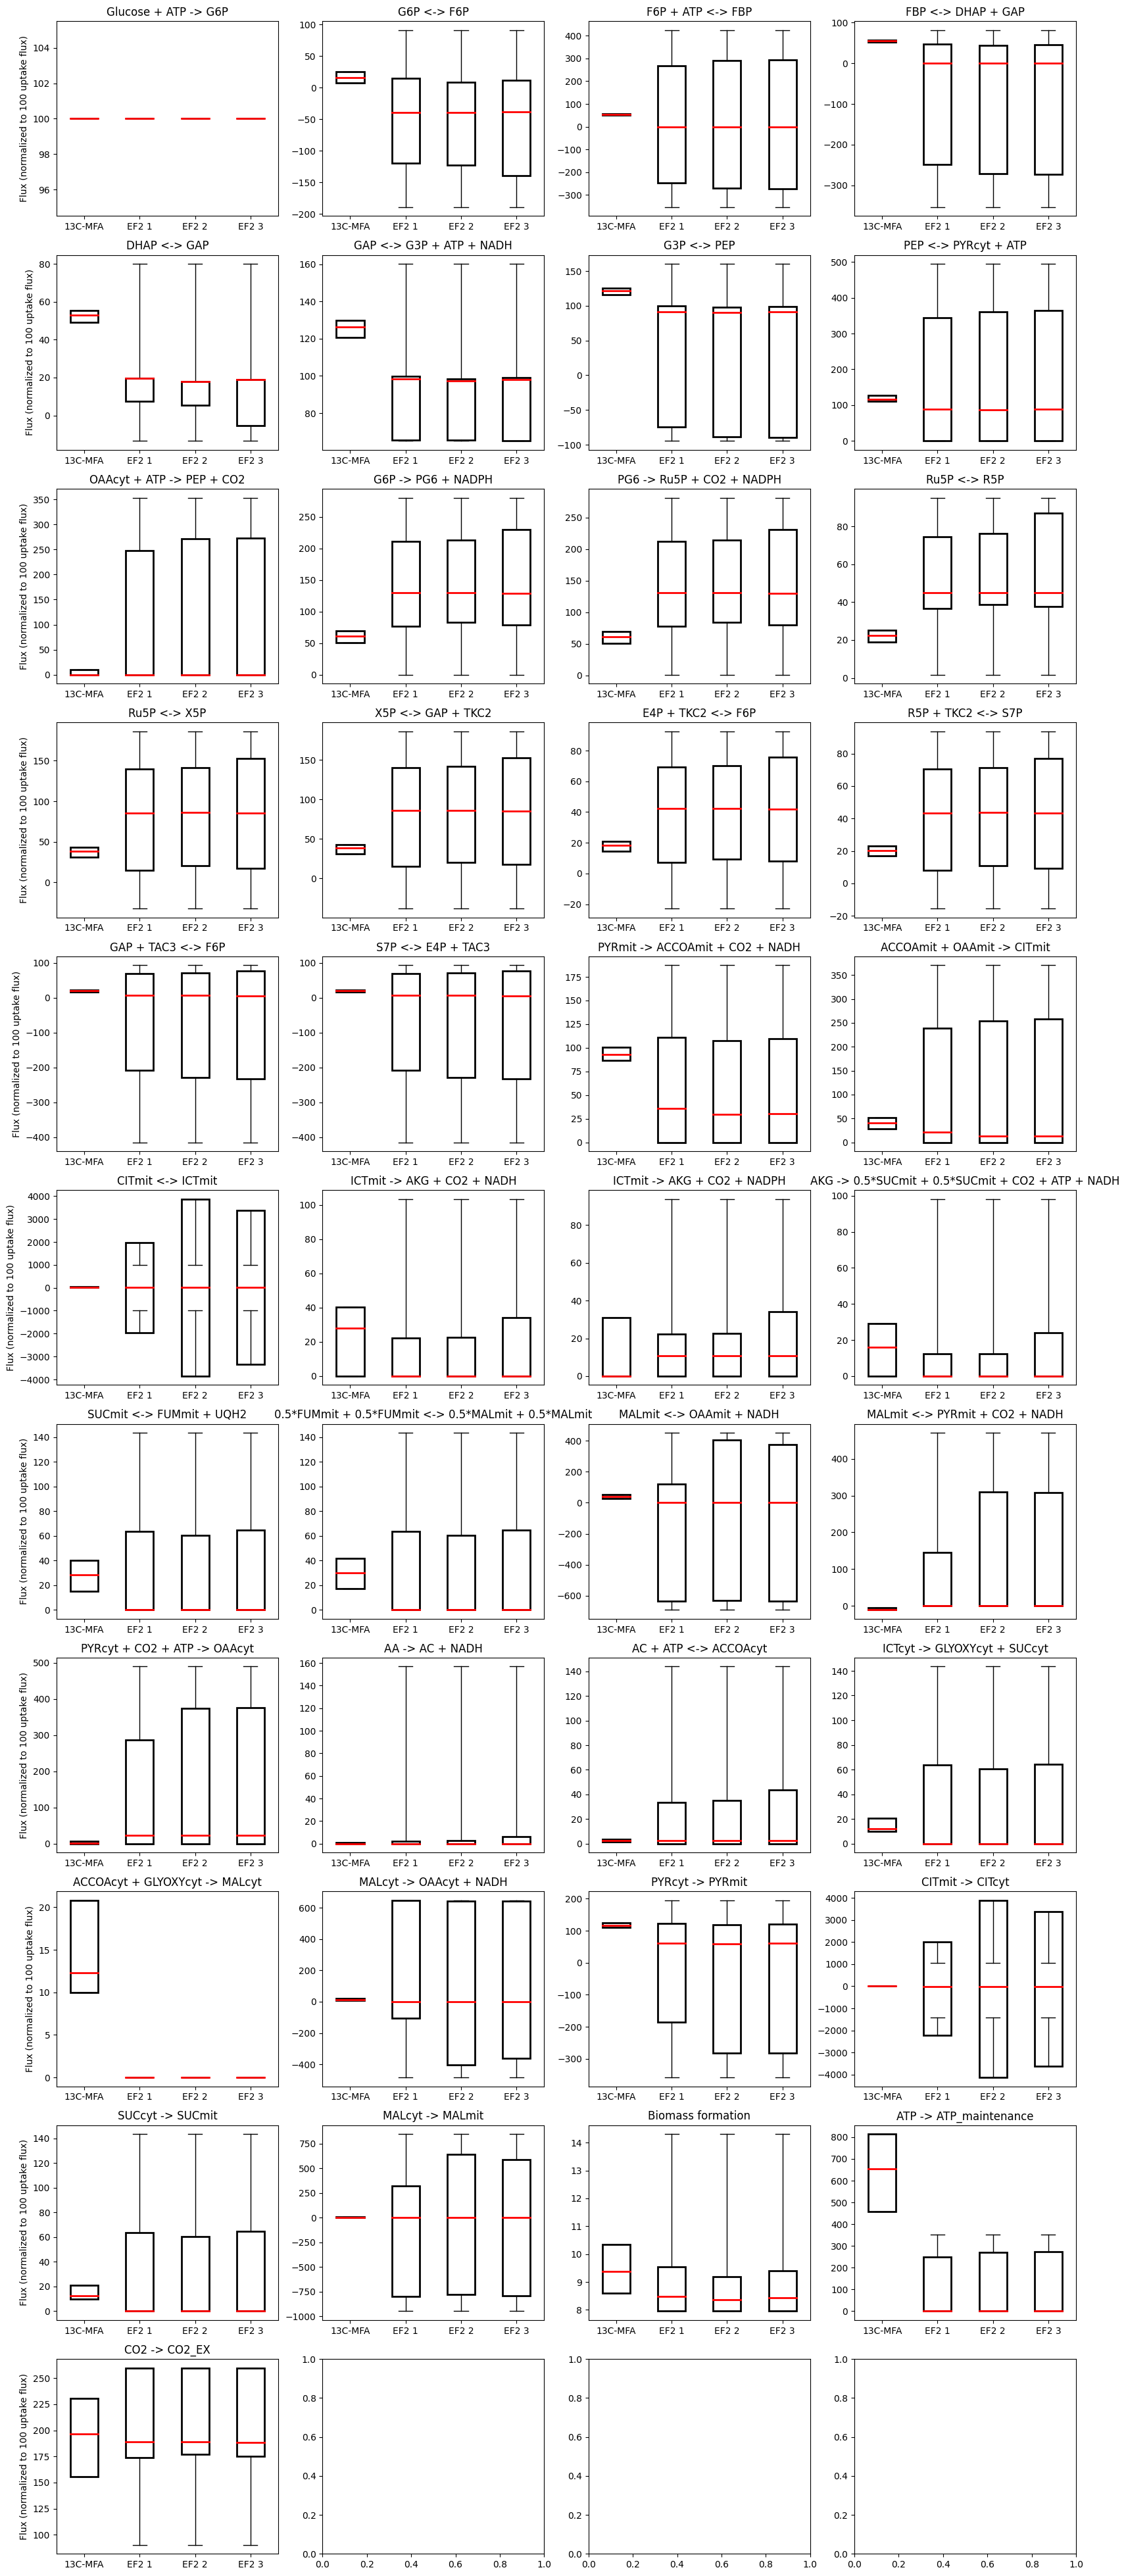

In [11]:
make_4_boxplot_grid(glucose_central_rxn_df, 'glucose')

# Glycerol

### Calculate the FVA biomass cutoff with quick pFBA and E-Flux2 test

In [12]:
glycerol_pfba_biomass_flux = get_pfba_biomass_flux(
  model=model, 
  substrate='glycerol'
)
print(f'glycerol max pfba biomass flux: {glycerol_pfba_biomass_flux} g biomass per 100 mmols glycerol')

eflux2_biomass_fluxes = get_eflux2_biomass_fluxes(
    model=model, 
    substrate='glycerol',
    reaction_transcript_dictionary_list=[
        glycerol_1_reaction_transcripts, 
        glycerol_2_reaction_transcripts, 
        glycerol_3_reaction_transcripts
    ]
)

print(f'E-Flux2 Biomass Fluxes: {eflux2_biomass_fluxes}')

minimum_eflux2_biomass_flux = min(eflux2_biomass_fluxes)
print(f'glycerol minimum eflux2 biomass flux: {minimum_eflux2_biomass_flux} g biomass per 100 mmols glycerol')

fva_biomass_cutoff = 0.95 * minimum_eflux2_biomass_flux

print(f'glycerol FVA biomass cutoff flux: {fva_biomass_cutoff} g biomass per 100 mmols glycerol')

glycerol max pfba biomass flux: 3.97729533513 g biomass per 100 mmols glycerol
E-Flux2 Biomass Fluxes: [1.8131274174543623, 1.8128737605816572, 2.127427997747974]
glycerol minimum eflux2 biomass flux: 1.8128737605816572 g biomass per 100 mmols glycerol
glycerol FVA biomass cutoff flux: 1.7222300725525743 g biomass per 100 mmols glycerol


### Create genome-scale dataframe with pFBA, E-Flux2, and bounds from FVA

In [13]:
glycerol_gsm_df = get_eflux2_fva_fluxes(
    model=model, 
    substrate='glycerol',
    reaction_transcript_dictionary_list=[
        glycerol_1_reaction_transcripts, 
        glycerol_2_reaction_transcripts, 
        glycerol_3_reaction_transcripts
    ],
    biomass_cutoff=fva_biomass_cutoff
)

# save as csv
glycerol_gsm_df.to_csv('../results/gsm_fluxes/glycerol_gsm_fluxes.csv', index=False)

glycerol_gsm_df.head()

Running pFBA FVA with the constraints: EX_glyc_e = -100, biomass_glucose >= 1.7222300725525743:
GLCS2 bounds: (0.0, 1000.0)
ran pfba fva
transcript constrained uptake flux: -21.956133355036
transcript constrained biomass flux: 0.398092673673
ran eflux2 fva
transcript constrained uptake flux: -20.83309235315
transcript constrained biomass flux: 0.377677664788
ran eflux2 fva
transcript constrained uptake flux: -11.515318362611
transcript constrained biomass flux: 0.244980106876
ran eflux2 fva


,reaction_id,reaction_name,full_reaction,glycerol_pfba_flux,glycerol_pfba_LB,glycerol_pfba_UB,glycerol_1_eflux2_flux,glycerol_1_trans_LB,glycerol_1_trans_UB,glycerol_1_eflux2_LB,...,glycerol_2_eflux2_flux,glycerol_2_trans_LB,glycerol_2_trans_UB,glycerol_2_eflux2_LB,glycerol_2_eflux2_UB,glycerol_3_eflux2_flux,glycerol_3_trans_LB,glycerol_3_trans_UB,glycerol_3_eflux2_LB,glycerol_3_eflux2_UB
689,H2Otm,H2O transport mitochondrial,h2o[c] <=> h2o[m],-569.931600,-1000.000000,-155.066579,-437.692805,-inf,inf,-1424.349923,...,-429.866151,-inf,inf,-1447.336116,-387.590624,-411.384352,-inf,inf,-2325.529535,-280.676778
959,H2Ot,H2O transport via diffusion,h2o[e] <=> h2o[c],-356.302123,-541.718857,-200.049567,-220.748574,-inf,inf,-240.048792,...,-219.908839,-inf,inf,-240.048792,-207.792346,-248.636215,-inf,inf,-313.614211,-200.458860
421,EX_h2o_e,H2O exchange,h2o[e] <=>,356.302123,200.049567,541.718857,220.748574,-4.554536e+04,4554.536010,213.655278,...,219.908839,-4.800056e+04,4800.055522,207.792346,240.048792,248.636215,-8.684085e+04,8684.084699,200.458860,313.614211
976,PIt2m,phosphate transporter mitochondrial,h[c] + pi[c] <=> h[m] + pi[m],313.718994,-176.009648,1000.000000,230.394981,-2.406161e+02,240.616137,117.089199,...,221.282024,-2.716351e+02,271.635142,75.779998,271.635142,210.058547,-4.795352e+02,479.535157,-48.851021,479.535157
607,ATPS3m,ATP synthase mitochondrial,adp[m] + 3.0 h[c] + pi[m] --> atp[m] + h2o[m] ...,310.127361,104.573313,657.411356,252.405864,0.000000e+00,635.904318,236.318847,...,252.552328,0.000000e+00,757.832766,235.723602,286.692322,244.700660,0.000000e+00,1201.529959,175.154914,348.900460


### Create a glycerol central reaction dataframe from genome-scale predictions

In [14]:
glycerol_central_rxn_df = central_rxn_df.copy()

# add pfba flux column
glycerol_central_rxn_df = add_flux_column_to_13c_flux_df(glycerol_central_rxn_df, glycerol_gsm_df, 'glycerol_pfba_flux')
glycerol_central_rxn_df = add_fva_columns_to_13c_flux_df(glycerol_central_rxn_df, glycerol_gsm_df, 'glycerol_pfba_LB', 'glycerol_pfba_UB')

# loop over the three eflux2 fluxes and add them to the dataframe
for substrate_trial in ['glycerol_1', 'glycerol_2', 'glycerol_3']:
    # add glycerol eflux2 data for the specific trial
    glycerol_central_rxn_df = add_flux_column_to_13c_flux_df(glycerol_central_rxn_df, glycerol_gsm_df, f'{substrate_trial}_eflux2_flux')
    glycerol_central_rxn_df = add_fva_columns_to_13c_flux_df(glycerol_central_rxn_df, glycerol_gsm_df, f'{substrate_trial}_eflux2_LB', f'{substrate_trial}_eflux2_UB')
    glycerol_central_rxn_df = add_transcript_values_to_13c_flux_df(glycerol_central_rxn_df, glycerol_gsm_df, f'{substrate_trial}_trans_LB', f'{substrate_trial}_trans_UB')

# save as csv
glycerol_central_rxn_df.to_csv('../results/central_fluxes/glycerol_central_fluxes.csv', index=False)

glycerol_central_rxn_df

reverse_EX_glc_e
reverse_GLYCt
OCDCEAt
PGI
PFK
reverse_FBP
FBA
TPI
GAPD
ENO
PYK
PPCK
G6PDH2
GND
reverse_RPI
RPE
TKT1
TKT2
TKT2
TKT1
TALA
TALA
PDHm
CSm
ACONTm
ICDHxm
ICDHym
AKGDam
AKGDbm
SUCD2_u6m
SUCD1m
FUMm
MDHm
ME1m
PC
ALDD2y
ACS
reverse_ACOAH
ICL
MALSp
MDH
PYRt2m
CITtam
CITtbm
CITtcm
SUCCtm
MALtm
reverse_CITtam
reverse_DICtm
biomass_C
biomass_glucose
biomass_oil
ATPM
reverse_CO2t
reverse_EX_glc_e
reverse_GLYCt
OCDCEAt
PGI
PFK
reverse_FBP
FBA
TPI
GAPD
ENO
PYK
PPCK
G6PDH2
GND
reverse_RPI
RPE
TKT1
TKT2
TKT2
TKT1
TALA
TALA
PDHm
CSm
ACONTm
ICDHxm
ICDHym
AKGDam
AKGDbm
SUCD2_u6m
SUCD1m
FUMm
MDHm
ME1m
PC
ALDD2y
ACS
reverse_ACOAH
ICL
MALSp
MDH
PYRt2m
CITtam
CITtbm
CITtcm
SUCCtm
MALtm
reverse_CITtam
reverse_DICtm
biomass_C
biomass_glucose
biomass_oil
ATPM
reverse_CO2t
reverse_EX_glc_e
reverse_GLYCt
OCDCEAt
PGI
PFK
reverse_FBP
FBA
TPI
GAPD
ENO
PYK
PPCK
G6PDH2
GND
reverse_RPI
RPE
TKT1
TKT2
TKT2
TKT1
TALA
TALA
PDHm
CSm
ACONTm
ICDHxm
ICDHym
AKGDam
AKGDbm
SUCD2_u6m
SUCD1m
FUMm
MDHm
ME1m
PC
ALDD2y


,Unnamed: 0,ID,Equation,reaction_ids,pathway,compartment,glucose_flux,glucose_std_err,glucose_LB,glucose_UB,...,glycerol_2_eflux2_flux,glycerol_2_eflux2_LB,glycerol_2_eflux2_UB,glycerol_2_trans_LB,glycerol_2_trans_UB,glycerol_3_eflux2_flux,glycerol_3_eflux2_LB,glycerol_3_eflux2_UB,glycerol_3_trans_LB,glycerol_3_trans_UB
0,uptake,uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,substrate_uptake,cytosol,100.0000,5590.0000,100.0000,100.0000,...,0.0,0.0,0.0,-4800.055522,0.0,0.0,0.0,0.0,-8684.084699,0.0
1,uptake,R3 glyc3p,GLYC + ATP -> Glyc3P,reverse_GLYCt,emp,cytosol,NaN,NaN,NaN,NaN,...,100.0,100.0,100.0,-10803.532965,10803.532965,100.0,100.0,100.0,-23343.774921,23343.774921
2,uptake,R3 dhap net,Glyc3P <-> DHAP + UQH2,NaN,emp,cytosol,NaN,NaN,NaN,NaN,...,,,,,,,,,,
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 7*NADH + 7*FADH2,OCDCEAt,substrate_uptake,cytosol,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,inf,0.0,0.0,0.0,0.0,inf
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,emp,cytosol,16.1585,903.3512,7.6380,25.0760,...,-2.037532,-17.124023,-1.935655,-4278.289487,4278.289487,-2.391067,-43.254541,-1.935655,-7155.42527,7155.42527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,biomass formation,R80 steph AC,0.294*ALA + 0.174*ARG + 0.196*ASN + 0.196*ASP ...,biomass_C or biomass_glucose or biomass_oil,biomass_formation,cytosol,9.3883,524.8236,8.6023,10.3466,...,1.812874,1.72223,1.992531,0.0,inf,2.127428,1.72223,2.930538,0.0,inf
67,energy metabolism,R81,ATP -> ATP_maintenance,ATPM,energy_metabolism,cytosol,653.3256,36521.0000,457.2097,813.9649,...,0.0,0.0,23.644442,0.0,inf,0.0,0.0,88.872038,0.0,inf
68,energy metabolism,R82,NADH -> NADPH,NaN,NaN,NaN,15.0638,60357.0000,0.0000,50.0149,...,,,,,,,,,,
69,energy metabolism,R83,NADH -> 2*ATP,NaN,NaN,NaN,294.9322,16486.0000,218.0630,356.4339,...,,,,,,,,,,


### Plot glycerol MFA vs E-Flux2 boxplots
pFBA lower and upper bounds are represented by whiskers

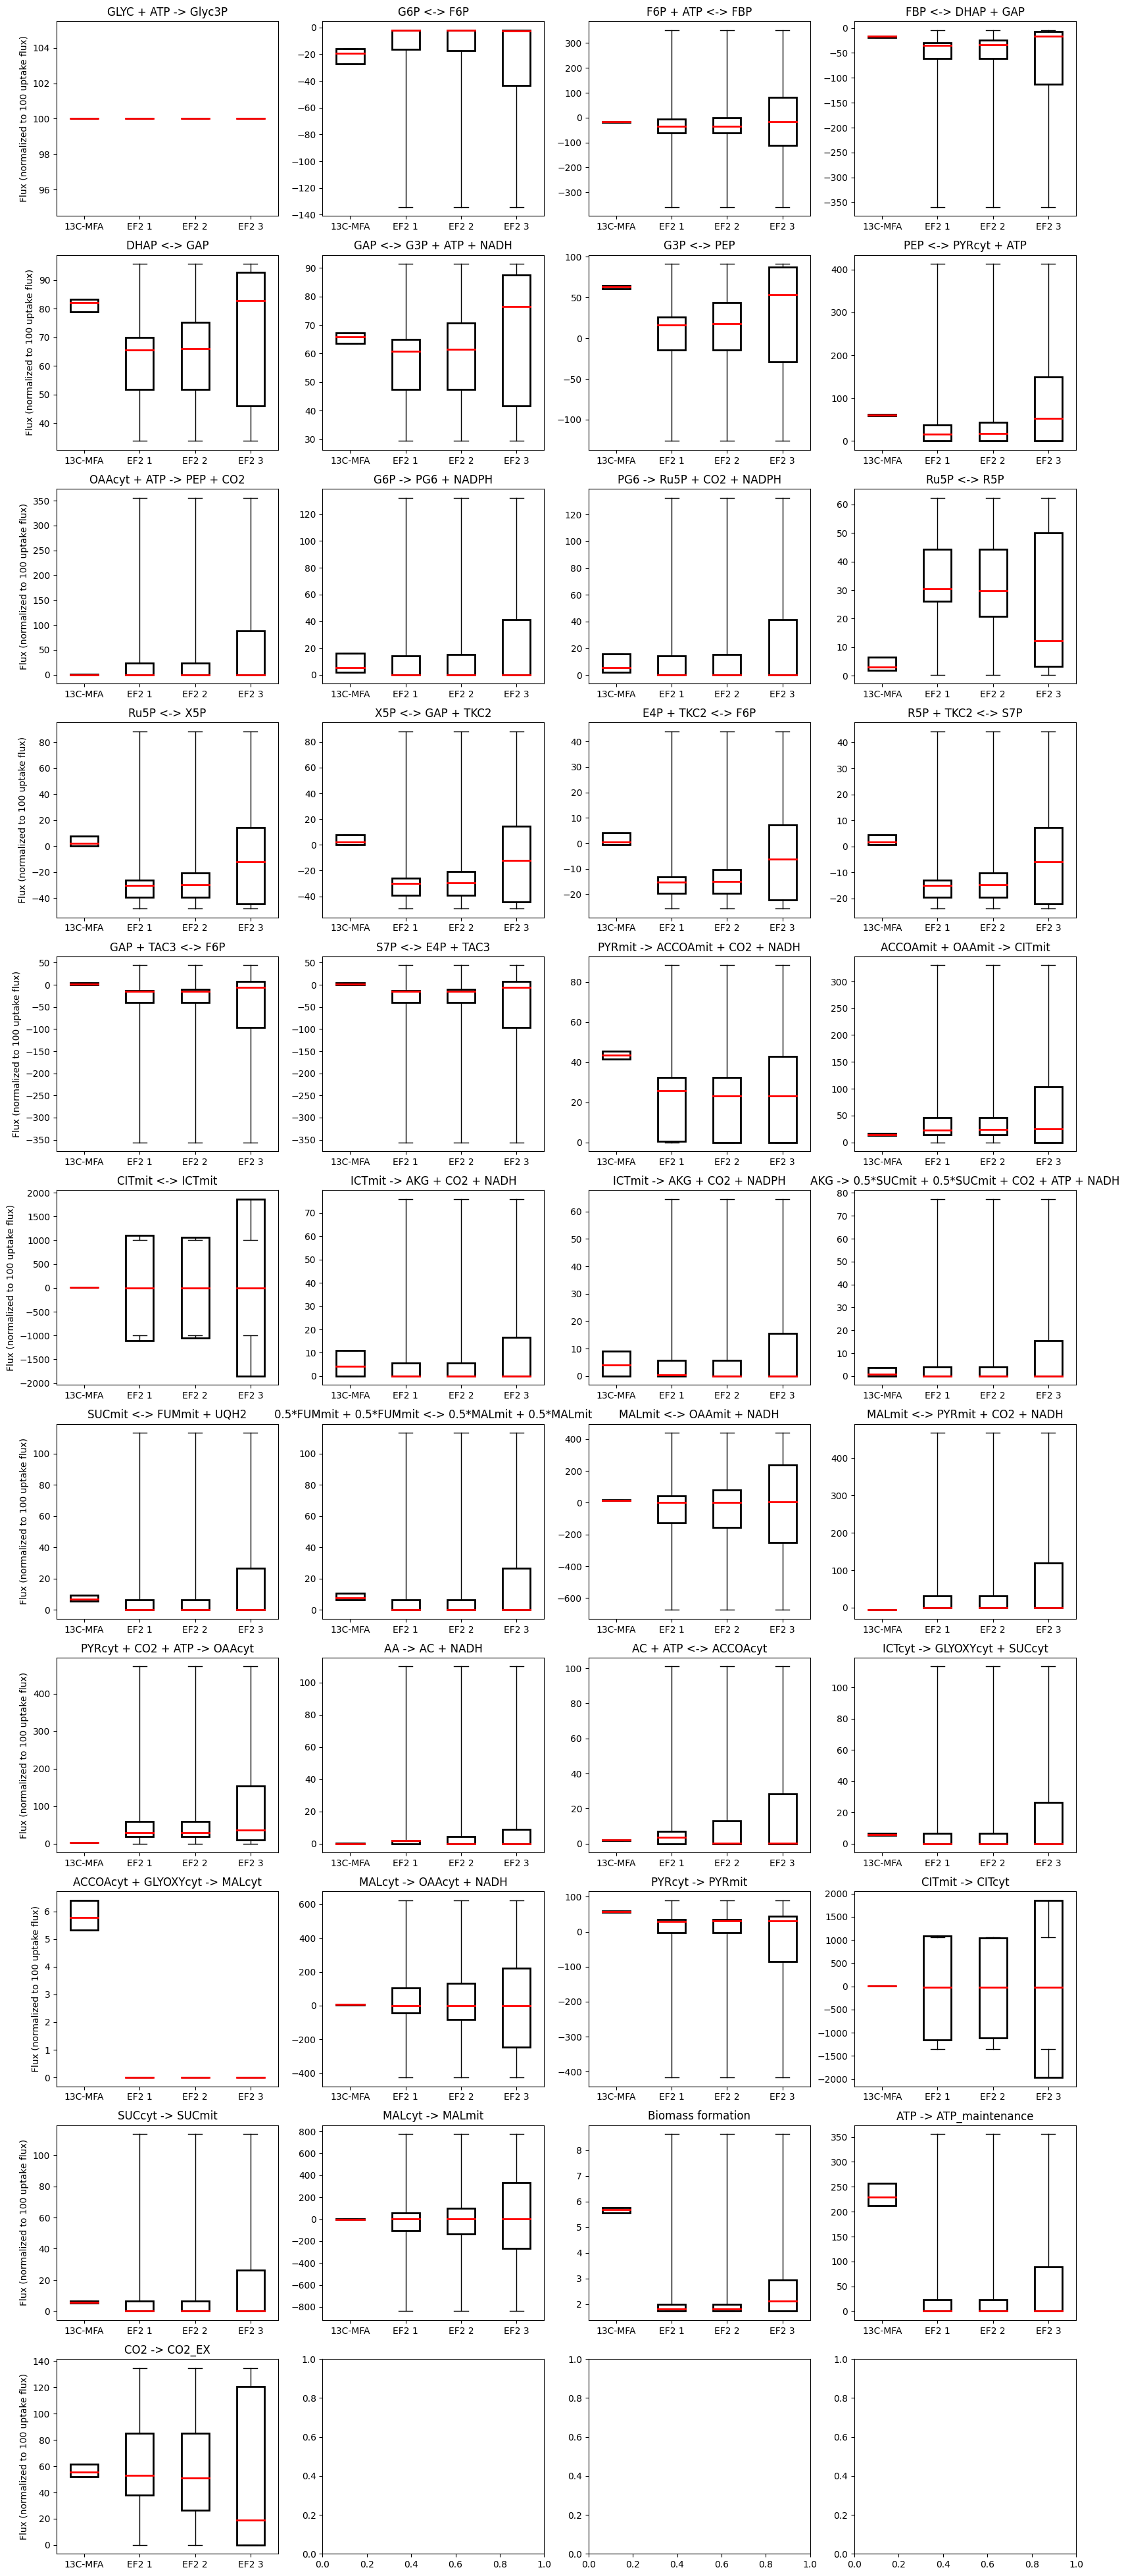

In [15]:
make_4_boxplot_grid(glycerol_central_rxn_df, 'glycerol')

# Oleic Acid

### Calculate the FVA biomass cutoff with quick pFBA and E-Flux2 test

In [16]:
oleic_acid_pfba_biomass_flux = get_pfba_biomass_flux(
  model=model, 
  substrate='oleic_acid'
)
print(f'oleic acid max pfba biomass flux: {oleic_acid_pfba_biomass_flux} g biomass per 100 mmols oleic acid')

eflux2_biomass_fluxes = get_eflux2_biomass_fluxes(
    model=model, 
    substrate='oleic_acid',
    reaction_transcript_dictionary_list=[
        oleic_acid_1_reaction_transcripts, 
        oleic_acid_2_reaction_transcripts, 
        oleic_acid_3_reaction_transcripts
    ]
)

print(f'E-Flux2 Biomass Fluxes: {eflux2_biomass_fluxes}')

minimum_eflux2_biomass_flux = min(eflux2_biomass_fluxes)
print(f'oleic acid minimum eflux2 biomass flux: {minimum_eflux2_biomass_flux} g biomass per 100 mmols oleic acid')

fva_biomass_cutoff = 0.95 * minimum_eflux2_biomass_flux

print(f'oleic acid FVA biomass cutoff flux: {fva_biomass_cutoff} g biomass per 100 mmols oleic acid')

oleic acid max pfba biomass flux: 25.52299955003 g biomass per 100 mmols oleic acid
E-Flux2 Biomass Fluxes: [25.112410132343438, 25.112410132341935, 25.11241013234567]
oleic acid minimum eflux2 biomass flux: 25.112410132341935 g biomass per 100 mmols oleic acid
oleic acid FVA biomass cutoff flux: 23.856789625724836 g biomass per 100 mmols oleic acid


### Create genome-scale dataframe with pFBA, E-Flux2, and bounds from FVA

In [17]:
oleic_acid_gsm_df = get_eflux2_fva_fluxes(
    model=model, 
    substrate='oleic_acid',
    reaction_transcript_dictionary_list=[
        oleic_acid_1_reaction_transcripts, 
        oleic_acid_2_reaction_transcripts, 
        oleic_acid_3_reaction_transcripts
    ],
    biomass_cutoff=fva_biomass_cutoff
)

# save as csv
oleic_acid_gsm_df.to_csv('../results/gsm_fluxes/oleic_acid_gsm_fluxes.csv', index=False)

oleic_acid_gsm_df.head()

Running pFBA FVA with the constraints: EX_ocdcea_e = -10, biomass_oil >= 2.385678962572484:
GLCS2 bounds: (0.0, 1000.0)
ran pfba fva
transcript constrained uptake flux: -2.377912643438
transcript constrained biomass flux: 0.597151175609
ran eflux2 fva
transcript constrained uptake flux: -1.035542602787
transcript constrained biomass flux: 0.260049705507
ran eflux2 fva
transcript constrained uptake flux: -1.495783759581
transcript constrained biomass flux: 0.375627352399
ran eflux2 fva


,reaction_id,reaction_name,full_reaction,oleic_acid_pfba_flux,oleic_acid_pfba_LB,oleic_acid_pfba_UB,oleic_acid_1_eflux2_flux,oleic_acid_1_trans_LB,oleic_acid_1_trans_UB,oleic_acid_1_eflux2_LB,...,oleic_acid_2_eflux2_flux,oleic_acid_2_trans_LB,oleic_acid_2_trans_UB,oleic_acid_2_eflux2_LB,oleic_acid_2_eflux2_UB,oleic_acid_3_eflux2_flux,oleic_acid_3_trans_LB,oleic_acid_3_trans_UB,oleic_acid_3_eflux2_LB,oleic_acid_3_eflux2_UB
689,H2Otm,H2O transport mitochondrial,h2o[c] <=> h2o[m],-3213.946143,-10000.000000,-2422.646870,-2781.168310,-inf,inf,-8976.268889,...,-2781.168310,-inf,inf,-16752.401042,-2422.646870,-2781.168310,-inf,inf,-12641.884127,-2422.646870
607,ATPS3m,ATP synthase mitochondrial,adp[m] + 3.0 h[c] + pi[m] --> atp[m] + h2o[m] ...,2082.556669,1848.677752,2390.812253,2024.923950,0.000000e+00,5.067470e+03,1848.677752,...,2024.923950,0.000000e+00,1.075958e+04,1848.677752,2390.812253,2024.923950,0.000000e+00,6.823179e+03,1848.677752,2390.812253
990,ATPtm_H,ADPATP transporter mitochondrial,adp[c] + atp[m] + h[c] --> adp[m] + atp[c] + h[m],2080.129927,1845.544775,2568.025331,2022.536248,0.000000e+00,1.147523e+05,1845.544775,...,2022.536248,0.000000e+00,3.847799e+05,1845.544775,2568.025331,2022.536248,0.000000e+00,2.212512e+05,1845.544775,2568.025331
976,PIt2m,phosphate transporter mitochondrial,h[c] + pi[c] <=> h[m] + pi[m],2080.129927,587.472294,3476.725539,2022.536248,-1.110133e+04,1.110133e+04,587.472294,...,2022.536248,-1.940239e+04,1.940239e+04,587.472294,3476.725539,2022.536248,-1.691889e+04,1.691889e+04,587.472294,3476.725539
617,CYOR_u6m,ubiquinol 6 cytochrome c reductase,2.0 ficytc[m] + 1.5 h[m] + q6h2[m] --> 2.0 foc...,1919.513974,1720.215907,2081.447581,1959.417642,0.000000e+00,5.833267e+03,1720.215907,...,1959.417642,0.000000e+00,1.820978e+04,1720.215907,2081.447581,1959.417642,0.000000e+00,7.331942e+03,1720.215907,2081.447581


### Create an oleic acid central reaction dataframe from genome-scale predictions

In [18]:
oleic_acid_central_rxn_df = central_rxn_df.copy()

# add pfba flux column
oleic_acid_central_rxn_df = add_flux_column_to_13c_flux_df(oleic_acid_central_rxn_df, oleic_acid_gsm_df, 'oleic_acid_pfba_flux')
oleic_acid_central_rxn_df = add_fva_columns_to_13c_flux_df(oleic_acid_central_rxn_df, oleic_acid_gsm_df, 'oleic_acid_pfba_LB', 'oleic_acid_pfba_UB')

# loop over the three eflux2 fluxes and add them to the dataframe
for substrate_trial in ['oleic_acid_1', 'oleic_acid_2', 'oleic_acid_3']:
    # add oleic_acid eflux2 data for the specific trial
    oleic_acid_central_rxn_df = add_flux_column_to_13c_flux_df(oleic_acid_central_rxn_df, oleic_acid_gsm_df, f'{substrate_trial}_eflux2_flux')
    oleic_acid_central_rxn_df = add_fva_columns_to_13c_flux_df(oleic_acid_central_rxn_df, oleic_acid_gsm_df, f'{substrate_trial}_eflux2_LB', f'{substrate_trial}_eflux2_UB')
    oleic_acid_central_rxn_df = add_transcript_values_to_13c_flux_df(oleic_acid_central_rxn_df, oleic_acid_gsm_df, f'{substrate_trial}_trans_LB', f'{substrate_trial}_trans_UB')

# save as csv
oleic_acid_central_rxn_df.to_csv('../results/central_fluxes/oleic_acid_central_fluxes.csv', index=False)

oleic_acid_central_rxn_df

reverse_EX_glc_e
reverse_GLYCt
OCDCEAt
PGI
PFK
reverse_FBP
FBA
TPI
GAPD
ENO
PYK
PPCK
G6PDH2
GND
reverse_RPI
RPE
TKT1
TKT2
TKT2
TKT1
TALA
TALA
PDHm
CSm
ACONTm
ICDHxm
ICDHym
AKGDam
AKGDbm
SUCD2_u6m
SUCD1m
FUMm
MDHm
ME1m
PC
ALDD2y
ACS
reverse_ACOAH
ICL
MALSp
MDH
PYRt2m
CITtam
CITtbm
CITtcm
SUCCtm
MALtm
reverse_CITtam
reverse_DICtm
biomass_C
biomass_glucose
biomass_oil
ATPM
reverse_CO2t
reverse_EX_glc_e
reverse_GLYCt
OCDCEAt
PGI
PFK
reverse_FBP
FBA
TPI
GAPD
ENO
PYK
PPCK
G6PDH2
GND
reverse_RPI
RPE
TKT1
TKT2
TKT2
TKT1
TALA
TALA
PDHm
CSm
ACONTm
ICDHxm
ICDHym
AKGDam
AKGDbm
SUCD2_u6m
SUCD1m
FUMm
MDHm
ME1m
PC
ALDD2y
ACS
reverse_ACOAH
ICL
MALSp
MDH
PYRt2m
CITtam
CITtbm
CITtcm
SUCCtm
MALtm
reverse_CITtam
reverse_DICtm
biomass_C
biomass_glucose
biomass_oil
ATPM
reverse_CO2t
reverse_EX_glc_e
reverse_GLYCt
OCDCEAt
PGI
PFK
reverse_FBP
FBA
TPI
GAPD
ENO
PYK
PPCK
G6PDH2
GND
reverse_RPI
RPE
TKT1
TKT2
TKT2
TKT1
TALA
TALA
PDHm
CSm
ACONTm
ICDHxm
ICDHym
AKGDam
AKGDbm
SUCD2_u6m
SUCD1m
FUMm
MDHm
ME1m
PC
ALDD2y


,Unnamed: 0,ID,Equation,reaction_ids,pathway,compartment,glucose_flux,glucose_std_err,glucose_LB,glucose_UB,...,oleic_acid_2_eflux2_flux,oleic_acid_2_eflux2_LB,oleic_acid_2_eflux2_UB,oleic_acid_2_trans_LB,oleic_acid_2_trans_UB,oleic_acid_3_eflux2_flux,oleic_acid_3_eflux2_LB,oleic_acid_3_eflux2_UB,oleic_acid_3_trans_LB,oleic_acid_3_trans_UB
0,uptake,uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,substrate_uptake,cytosol,100.0000,5590.0000,100.0000,100.0000,...,0.0,0.0,0.0,-96567.731478,0.0,0.0,0.0,0.0,-66854.583331,0.0
1,uptake,R3 glyc3p,GLYC + ATP -> Glyc3P,reverse_GLYCt,emp,cytosol,NaN,NaN,NaN,NaN,...,0.0,-22.116175,0.0,-426639.134702,426639.134702,0.0,-22.116175,0.0,-245340.275725,245340.275725
2,uptake,R3 dhap net,Glyc3P <-> DHAP + UQH2,NaN,emp,cytosol,NaN,NaN,NaN,NaN,...,,,,,,,,,,
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 7*NADH + 7*FADH2,OCDCEAt,substrate_uptake,cytosol,NaN,NaN,NaN,NaN,...,100.0,100.0,100.0,0.0,inf,100.0,100.0,100.0,0.0,inf
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,emp,cytosol,16.1585,903.3512,7.6380,25.0760,...,-31.89344,-434.781416,-30.298768,-80028.576108,80028.576108,-31.89344,-434.781416,-30.298768,-53654.145852,53654.145852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,biomass formation,R80 steph AC,0.294*ALA + 0.174*ARG + 0.196*ASN + 0.196*ASP ...,biomass_C or biomass_glucose or biomass_oil,biomass_formation,cytosol,9.3883,524.8236,8.6023,10.3466,...,25.11241,23.85679,27.825009,0.0,inf,25.11241,23.85679,27.825009,0.0,inf
67,energy metabolism,R81,ATP -> ATP_maintenance,ATPM,energy_metabolism,cytosol,653.3256,36521.0000,457.2097,813.9649,...,0.0,0.0,406.38471,0.0,inf,0.0,0.0,406.38471,0.0,inf
68,energy metabolism,R82,NADH -> NADPH,NaN,NaN,NaN,15.0638,60357.0000,0.0000,50.0149,...,,,,,,,,,,
69,energy metabolism,R83,NADH -> 2*ATP,NaN,NaN,NaN,294.9322,16486.0000,218.0630,356.4339,...,,,,,,,,,,


### Plot oleic acid MFA vs E-Flux2 boxplots
pFBA lower and upper bounds are represented by whiskers

In [19]:
make_4_boxplot_grid(oleic_acid_central_rxn_df, 'oleic_acid')

: 

: 